In [1]:
%load_ext autoreload

In [492]:
%autoreload
import numpy as np
import geopandas as gpd
import geovoronoi
import matplotlib.pyplot as plt
import matplotlib
from tqdm.auto import tqdm
from jx.spatial import geo_to_nb, nb_to_graph
import cmdstanpy
import pears
import cmasher as cmr
from scipy.spatial import Delaunay
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['figure.figsize'] = (11, 7)

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [4]:
area = world[world.name == 'Germany']

In [5]:
area = area.to_crs(epsg=3395)    # convert to World Mercator CRS
area_shape = area.iloc[0].geometry   # get the Polygon

<AxesSubplot:>

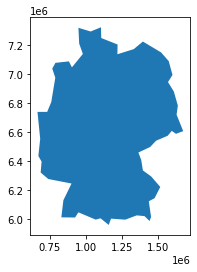

In [6]:
area.plot()

In [522]:
minx, miny, maxx, maxy = area_shape.bounds

nx = 10
ny = 10
linx = np.linspace(minx, maxx, nx)
liny = np.linspace(miny, maxy, ny)
gridx, gridy = np.meshgrid(linx, liny)
gridx = gridx.flatten()
gridy = gridy.flatten()
# gridz = np.repeat(np.nan, nx*ny)
gridz = np.random.poisson((gridx + gridy) / 1e4)

# nmeas = 50
# measx = np.random.uniform(minx, maxx, nmeas)
# measy = np.random.uniform(miny, maxy, nmeas)
# measz = np.random.poisson(np.abs(measx - measy) / 1e6)

# gridx = np.append(gridx, measx)
# gridy = np.append(gridy, measy)
# gridz = np.append(gridz, measz)

# idx = np.random.choice(np.arange(nx*ny), size=int(1*nx*ny), replace=False)
# gridz[idx] = gridx[idx] - gridy[idx]

coords = np.vstack((gridx, gridy)).T

In [523]:
ptsz = [(p, idx) for idx, p in tqdm(enumerate(geovoronoi.coords_to_points(coords)), total=nx*ny) if p.within(area_shape)]  # converts to shapely Point
pts, idx = list(zip(*ptsz))

  0%|          | 0/100 [00:00<?, ?it/s]

In [524]:
region_polys, region_pts = geovoronoi.voronoi_regions_from_coords(pts, area_shape, per_geom=False)

In [525]:
df = gpd.GeoDataFrame(dict(z=np.array([gridz[np.array(idx)][v[0]] for v in region_pts.values()])), geometry=gpd.GeoSeries(region_polys))

In [526]:
df['x'] = df.geometry.apply(lambda x: x.centroid.x)
df['y'] = df.geometry.apply(lambda x: x.centroid.y)
df['theta'] = np.random.normal(size=len(df))
df['meas'] = np.random.normal(-df['x'] - np.sqrt(df['y']), (df['x'].std() + df['y'].std()) / 1e3) / 1e3
df['E'] = np.random.poisson(np.random.normal(np.abs(df['x'] + df['y']) / 1e2, scale=1e3) / 1e1)
df['phi'] = np.random.normal(df['meas'] * 0.5, df['meas'].std() * 1e3) / 6e6
# df['z'] = np.random.poisson(df['E'] * np.exp(df['phi']))

In [527]:
randmiss = np.random.choice(np.arange(len(df)), size=int(0.5*len(df)), replace=False)
df['zobs'] = df['z']
df['zobs'][df.index.isin(randmiss)] = np.nan
df = df.sort_values(by='z').reset_index().drop('index', 1)

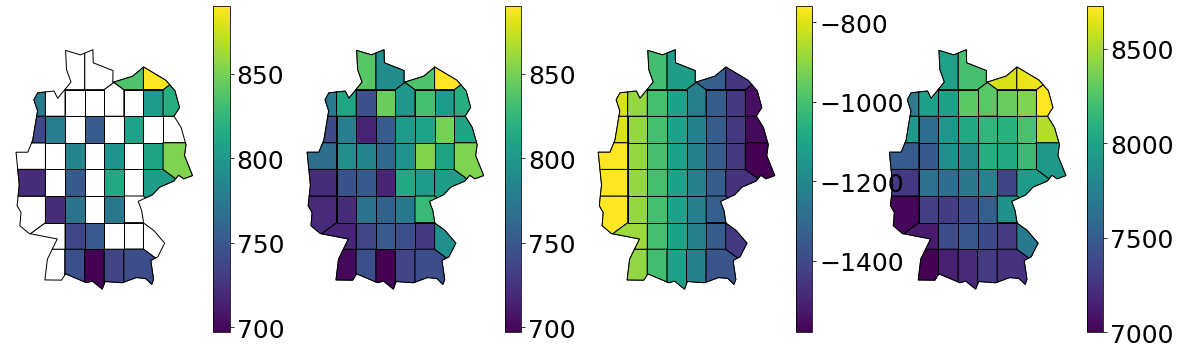

In [530]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

df.plot(ax=ax1, edgecolor='k', color='white')
df.plot('zobs', ax=ax1, edgecolor='k', legend=True)

df.plot(ax=ax2, edgecolor='k', color='white')
df.plot('z', ax=ax2, edgecolor='k', legend=True)

df.plot(ax=ax3, edgecolor='k', color='white')
df.plot('meas', ax=ax3, edgecolor='k', legend=True)

df.plot(ax=ax4, edgecolor='k', color='white')
df.plot('E', ax=ax4, edgecolor='k', legend=True)

for a in [ax1, ax2, ax3, ax4]:
    a.axis('off')
# ax2.scatter(gridx, gridy, c=gridz)

In [207]:
nb = geo_to_nb(df)
node1, node2 = nb_to_graph(nb)

  0%|          | 0/52 [00:00<?, ?it/s]

In [494]:
robjects.r('''
# compute scaling factor for a fully connected areal map
# accounts for differences in spatial connectivity
scaling_factor <- function(node1, node2) {
    adj_matrix = sparseMatrix(i=node1,j=node2,x=1,symmetric=TRUE)

    N = dim(adj_matrix)[1]

    # Create ICAR precision matrix  (diag - adjacency): this is singular
    # function Diagonal creates a square matrix with given diagonal
    Q =  Diagonal(N, rowSums(adj_matrix)) - adj_matrix

    # Add a small jitter to the diagonal for numerical stability (optional but recommended)
    Q_pert = Q + Diagonal(N) * max(diag(Q)) * sqrt(.Machine$double.eps)

    # Function inla.qinv provides efficient way to calculate the elements of the
    # the inverse corresponding to the non-zero elements of Q
    Q_inv = inla.qinv(Q_pert, constr=list(A = matrix(1,1,N),e=0))

    # Compute the geometric mean of the variances, which are on the diagonal of Q.inv
    scaling_factor <- exp(mean(log((Matrix::diag(Q_inv)))))
    return(scaling_factor) 
}
'''
)

def r_scaling_factor(node1, node2):
    return robjects.globalenv['scaling_factor'](
        robjects.FloatVector(node1 + 1),
        robjects.FloatVector(node2 + 1),
    )[0]

In [495]:
scaling_factor = r_scaling_factor(node1, node2)

In [558]:
model = cmdstanpy.CmdStanModel(stan_file='../jx/stanmodels/counts.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [560]:
mask = ~df['zobs'].isna()

data=dict(
    N = len(df),
    N_obs = mask.sum(),
    obs_idx = df.index[mask],
    N_edges = node1.size,
    node1 = node1 + 1,
    node2 = node2 + 1,
    y = df['zobs'][mask].astype(int),
    E = np.ones(len(df)),
    x = df['meas'],
    scaling_factor=scaling_factor,
    X1 = df['x'],
    X2 = df['y'],
)

try:
    opt = model.optimize(data=data)
except:
    pass

sm = model.sample(data=data, inits=opt.stan_variables(), iter_warmup=3000)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [561]:
print(sm.diagnose())

Processing csv files: /tmp/tmpgt1goqfd/counts-20220426003511_1.csv, /tmp/tmpgt1goqfd/counts-20220426003511_2.csv, /tmp/tmpgt1goqfd/counts-20220426003511_3.csv, /tmp/tmpgt1goqfd/counts-20220426003511_4.csv

Checking sampler transitions treedepth.
4000 of 4000 (1e+02%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.001, is below the nominal threshold of 0.3 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

The following parameters had fewer than 0.001 effective draws per transition:
  beta0, beta1, sigma, phi[7], phi[10], phi[11], phi[16], phi[19], phi[23], phi[25], phi[41], phi[44], phi[46], phi[5

In [506]:
pred_old = copy.deepcopy(pred)

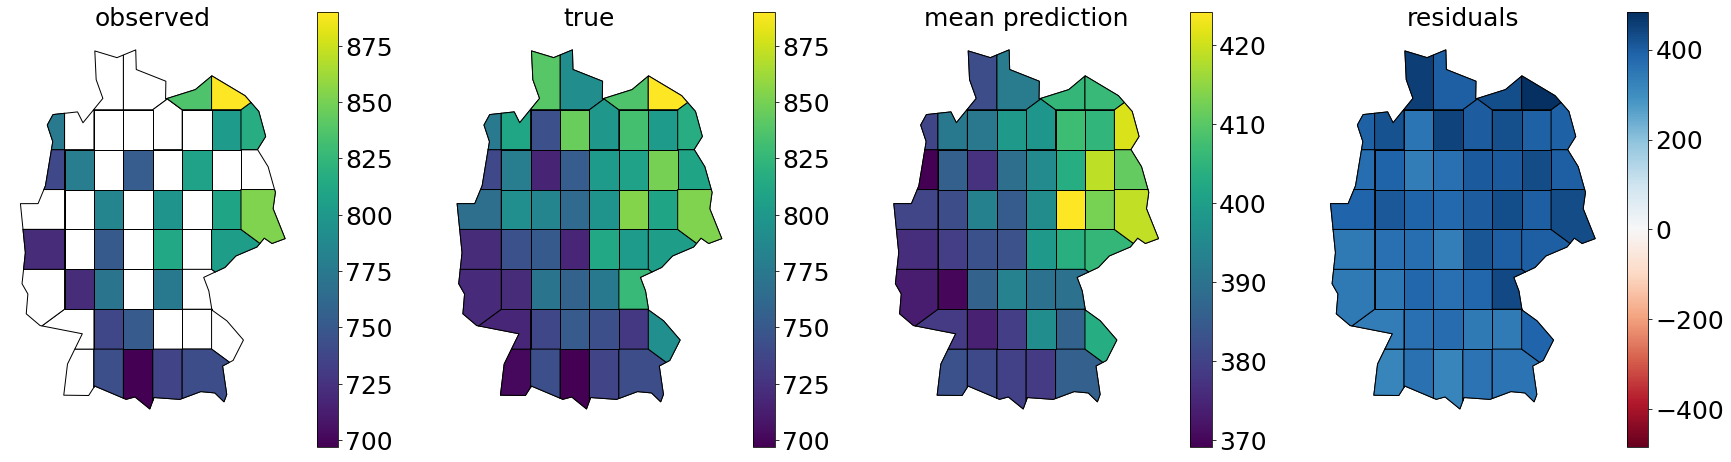

In [562]:
fig = plt.figure(figsize=(30, 8))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

pred = sm.stan_variable('mu').mean(axis=0)
err = df['z'] - pred
norm = matplotlib.colors.CenteredNorm(halfrange=err.abs().max())

df.plot(ax=ax1, edgecolor='k', color='white')
df.plot('zobs', ax=ax1, edgecolor='k', legend=True)
ax1.set_title('observed')

df.plot(ax=ax2, edgecolor='k', color='white')
df.plot('z', ax=ax2, edgecolor='k', legend=True)
ax2.set_title('true')

df.plot(ax=ax3, edgecolor='k', color='white')
df.plot(pred, ax=ax3, edgecolor='k', legend=True)
ax3.set_title('mean prediction')

df.plot(ax=ax4, edgecolor='k', color='white')
df.plot(err, ax=ax4, edgecolor='k', cmap='RdBu', norm=norm, legend=True)
ax4.set_title('residuals')

for a in [ax1, ax2, ax3, ax4]:
    a.axis('off')

In [551]:
samples = jax.tree_map(lambda x: x[3000:], sm.stan_variables())

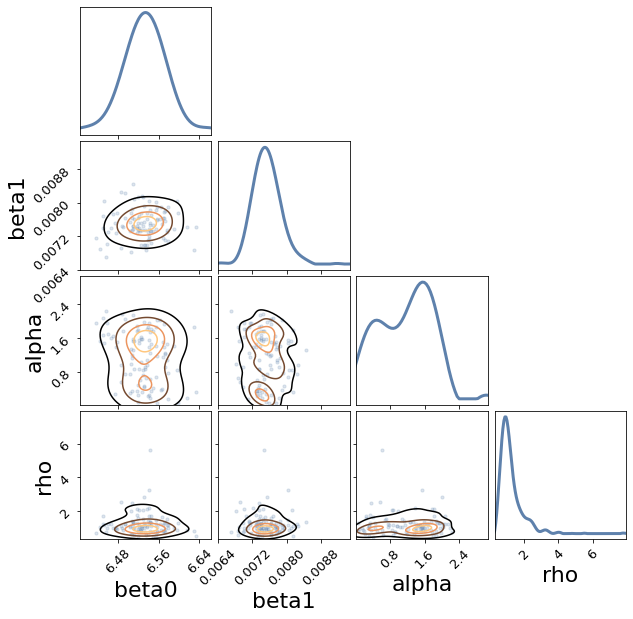

In [552]:
pears.pears(samples, indices=['beta0', 'beta1', 'alpha', 'rho'], scatter_thin=10);

In [520]:
tri = Delaunay(df[['x', 'y']])

<AxesSubplot:xlabel='x', ylabel='y'>

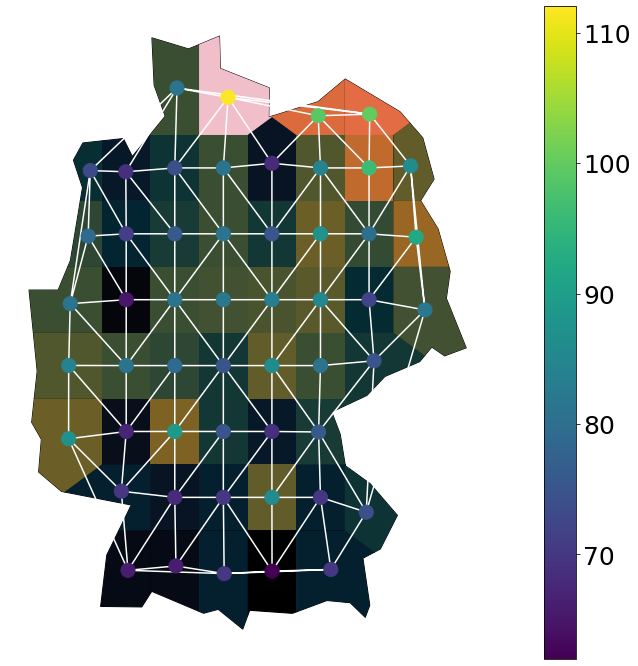

In [521]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot()
ax.axis('off')
df.plot(ax=ax, zorder=-10, color='lightgrey', edgecolor='k')
df.plot('z', ax=ax, cmap=cmr.dusk)
ax.triplot(df['x'], df['y'], tri.vertices, c='w')
df.plot(x='x', y='y', c=df['z'], cmap='viridis', s=200, ax=ax, kind='scatter')